In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import argrelextrema

In [3]:
omp = 1
mpi = 4

# RT preliminary analysis of GaAs

We perform various calculation with a single $k$ point to understand some aspects of the dynamics
of the polarization. In particular the topics to be addressed are, among the others:
* Decay time at single k, determination of the value of $\eta$ in term of the lenght of the simulation
* Circular vs linear polarization of the pump, are there some difference for the dynamics of the polarization?
* Identify the componenents of the polarizaion that are activated (both with or without the -nosym option)
* Study the frequency of oscillation of the polarization both during and after the pump. Seek for pump intensity 
    dependence of the frequency 

We build of the dictionary with the parameters of the various simulations.

In [4]:
simulations = {
    # low field simulations made to check the effect of the field polarization and the one of the -nosym option
    'gamma_circ': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_circ', 
        'field_int' : 1e3,
        'field_eng' : 1.42,
        'field_pol' : 'circular',
        'eta'       : 1e-4,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'gamma_lin': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_lin', 
        'field_int' : 1e3,
        'field_eng' : 1.42,
        'field_pol' : 'linear',
        'eta'       : 1e-4,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'gamma_circ_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_nosym', 
        'field_int' : 1e3,
        'field_eng' : 1.42,
        'field_pol' : 'circular',
        'eta'       : 1e-4,
        'no_sym'    : True,
        'obs_time'  : 0.01
    },
    # shift the pump frequency w.r.t the gap
    'gamma_shift': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_lin', 
        'field_int' : 1e3,
        'field_eng' : 1.45,
        'field_pol' : 'linear',
        'eta'       : 1e-4,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    # high field simulations (all performed with linear polarized pump)
    'gamma_f1e5': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_lin', 
        'field_int' : 1e5,
        'field_eng' : 1.42,
        'field_pol' : 'linear',
        'eta'       : 1e-4,
        'no_sym'    : False,
        'obs_time'  : 0.05
    },
    'gamma_f1e6': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_lin', 
        'field_int' : 1e6,
        'field_eng' : 1.42,
        'field_pol' : 'linear',
        'eta'       : 1e-4,
        'no_sym'    : False,
        'obs_time'  : 0.05
    },
    'gamma_f5e6': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_lin', 
        'field_int' : 5e6,
        'field_eng' : 1.42,
        'field_pol' : 'linear',
        'eta'       : 1e-4,
        'no_sym'    : False,
        'obs_time'  : 0.05
    },
    'gamma_f1e6_vel': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_Gamma_lin', 
        'field_int' : 1e6,
        'field_eng' : 1.42,
        'field_pol' : 'linear',
        'eta'       : 1e-4,
        'no_sym'    : False,
        'obs_time'  : 0.05,
        'Gauge'     : 'velocity'
    },
}

### Construction of the SAVE folder and FixSymm procedure

We build the SAVE folder, the FixSymm procedure is performed if needed.
The proper rt_run_dir key is added to the simulation dictionary

In [5]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

build SAVE and perform FixSymm for gamma_circ
SAVE folder already present in RT_Gamma_circ
FixSymm folder RT_Gamma_circ/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for gamma_lin
SAVE folder already present in RT_Gamma_lin
FixSymm folder RT_Gamma_lin/FixSymm already found. No operations performed.
 
build SAVE for gamma_circ_nosym sim with the -nosym option
SAVE folder already present in RT_Gamma_nosym
 
build SAVE and perform FixSymm for gamma_shift
SAVE folder already present in RT_Gamma_lin
FixSymm folder RT_Gamma_lin/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for gamma_f1e5
SAVE folder already present in RT_Gamma_lin
FixSymm folder RT_Gamma_lin/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for gamma_f1e6
SAVE folder already present in RT_Gamma_lin
FixSymm folder RT_Gamma_lin/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for gamma_f5e6
SAVE 

Remove the contribution of the pseudo from the commutator

In [6]:
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

mv RT_Gamma_circ/FixSymm/SAVE/ns.kb_pp_pwscf RT_Gamma_circ/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_Gamma_nosym/SAVE/ns.kb_pp_pwscf RT_Gamma_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf RT_Gamma_lin/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary

In [7]:
# Common parameters

field_width = 100 #fs set the width of the FWHM 
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as
sim_time = 1000 # fs

The obs_time has been set to 0.01 for the simulations in the low field regime to investigate the scattered behavior of the 
frequency of oscillations (some comments are reported below). The value 0.05 is chosen for the the high field simulations.

In [8]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=sim_time,time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

In [9]:
#simulations['gamma_f1e6_vel']

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [10]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=10)

#sel_sim = dict((k,simulations[k]) for k in ['gamma_circ','gamma_lin','gamma_circ_nosym','gamma_shift'])

for sim in simulations.values():
    idd = dict((k,sim[k]) for k in ['field_int','field_eng','eta'])
    if sim.get('Gauge') is not None:
        idd['gauge'] = sim['Gauge']
    name = D.name_from_id(idd)
    #print(name)
    results = code.run(inputs=[sim['input']],names=[name],run_dir=sim['rt_run_dir'])
    sim['results'] = P.YamboParser(results['output'][0])

Initialize a parallel Yambo calculator with scheduler direct
Skip the run of eta_0.0001-field_eng_1.42-field_int_1000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.42-field_int_1000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.42-field_int_1000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.45-field_int_1000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.42-field_int_100000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.42-field_int_1000000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.42-field_int_5000000.0
Job completed
Skip the run of eta_0.0001-field_eng_1.42-field_int_1000000.0-gauge_velocity
Job completed


We compare the various components of the polarization for the circular, linear and circular with nosym calculations

In [11]:
sel_sim = dict((k,simulations[k]) for k in ['gamma_circ','gamma_lin','gamma_circ_nosym'])

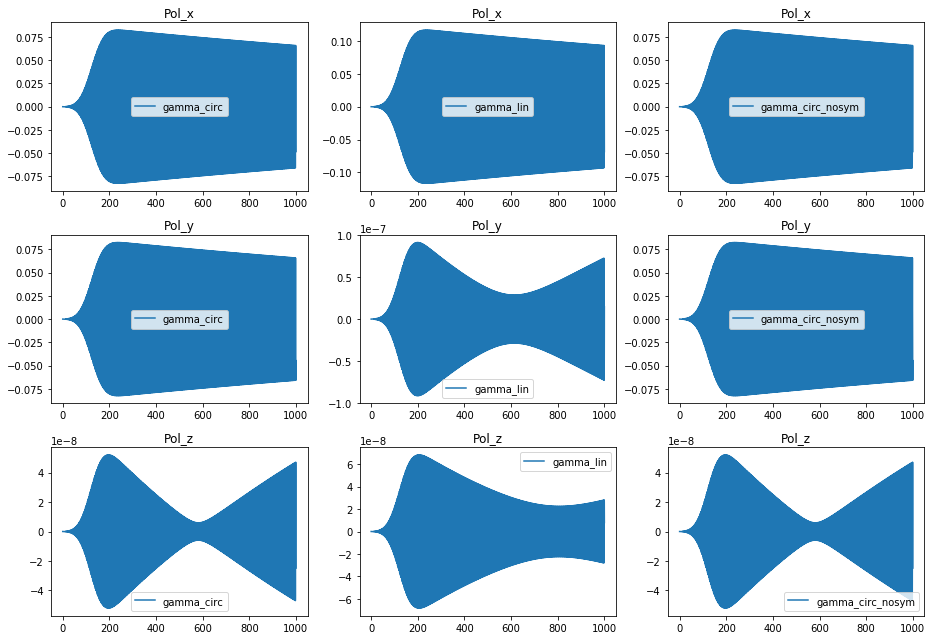

In [12]:
fig, axs = plt.subplots(3, 3,figsize=(13,9))
comps = ['Pol_x','Pol_y','Pol_z']
for ind_c,c in enumerate(comps):
    ind_s = 0
    for study,val in sel_sim.items():
        pol = val['results']['polarization']
        time = pol['time']
        p = pol[c]
        axs[ind_c,ind_s].plot(time,p,label=study)
        axs[ind_c,ind_s].set_title(c)
        axs[ind_c,ind_s].legend(loc='best')
        ind_s += 1
fig.tight_layout()

These plots show that the dielectric tensor is diagonal so, in the linear case where the field is parallel to the $x$ 
axis only the $x$ component of the polarization is activated. No significant differences are found if the -nosym option
is included but this is due to the fact that we are at $\Gamma$. This will further investigated for other $k$-points.

We compare the number of carriers in the various simulation

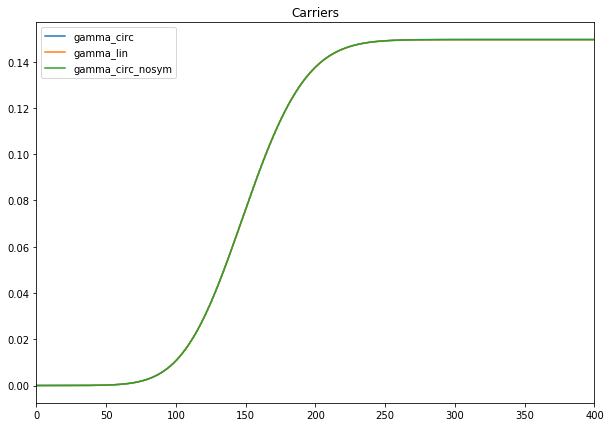

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

The number of carriers is the same in the various cases as expected. 

We investigate on the frequency of the oscillations. We consider the $x$ components for the linear polarization
and compute the period of the oscillations in function of time. We perform this analysis for both the cases of
pump energy resonant with the gap and with a small shift.

In [13]:
sel_sim = dict((k,simulations[k]) for k in ['gamma_lin','gamma_shift'])

In [14]:
time = {}
px = {}
t_max = {}
for study,vals in sel_sim.items():
    r = vals['results']['polarization']
    time[study] = r['time']
    px[study] = r['Pol_x']
    t_max[study] = time[study][argrelextrema(px[study], np.greater)[0]]

(-0.175066839, 0.1750639425)

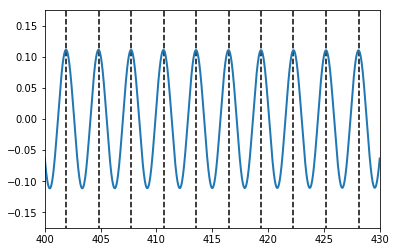

In [15]:
s = 'gamma_lin'
plt.plot(time[s],px[s],linewidth=2)
plt.vlines(t_max[s],-1,1,linestyles='--')
plt.xlim(400,430)
plt.ylim(1.5*min(px[s]),1.5*max(px[s]))

We compute the energy associated to the period of oscillation

In [16]:
freq = {}
for study in sel_sim:
    delta = [1] # set arbitrary to one to avoid divergence 
    for ind in range(len(t_max[study])-1):
        delta.append(t_max[study][ind+1]-t_max[study][ind])
    delta = np.array(delta)
    freq[study] = U.Planck_ev_ps*1e3/delta # E = hv with h in eV*fs

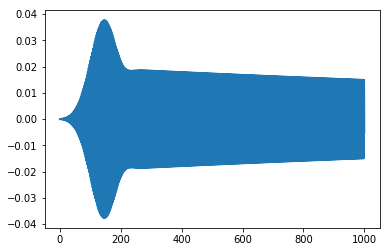

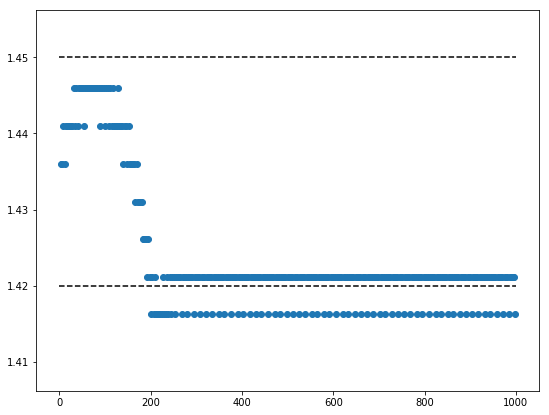

(400, 500)

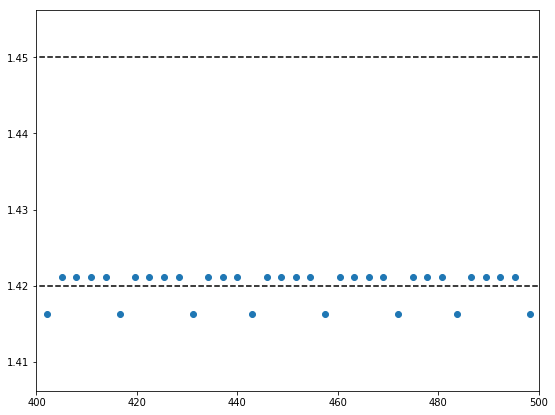

In [17]:
s = 'gamma_shift'

plt.plot(time[s],px[s],linewidth=2)
plt.show()

fig, ax = plt.subplots(figsize=(9, 7))
#plt.plot(t_max[s][1:],freq[s][1:],linewidth=2)
plt.scatter(t_max[s][1:],freq[s][1:])
plt.hlines(1.42,0,1000,linestyles='--')
plt.hlines(1.45,0,1000,linestyles='--')
plt.show()

fig, ax = plt.subplots(figsize=(9, 7))
#plt.plot(t_max[s][1:],freq[s][1:],linewidth=2)
plt.scatter(t_max[s][1:],freq[s][1:])
plt.hlines(1.42,0,1000,linestyles='--')
plt.hlines(1.45,0,1000,linestyles='--')
plt.xlim(400,500)

The scattered behavior is probably due to mutual incommensurability between the period
of oscillation and the sampling time. To be investigated further if needed. 

The plots evidence that when the pump is active the system is driven to a frequency that is a combination
of the one of the pump and of its natural frequency. In the zero pump regime the system oscillates with its
proper frequency.

### Analysis in the non-linear regime

In [31]:
sel_sim = dict((k,simulations[k]) for k in ['gamma_f1e5','gamma_f1e6']) #,'gamma_f5e6'])

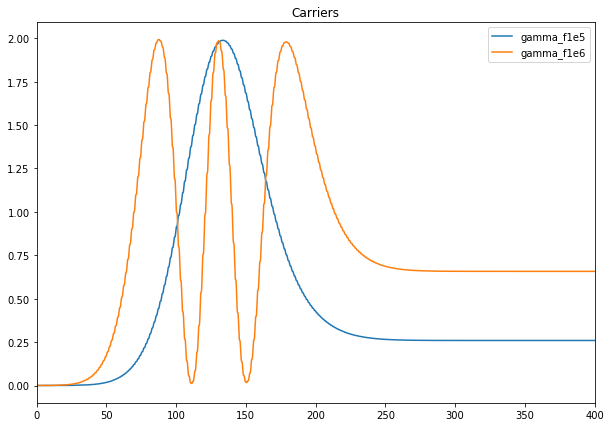

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

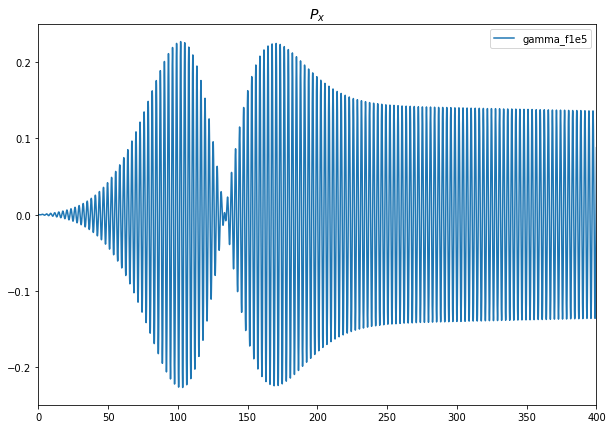

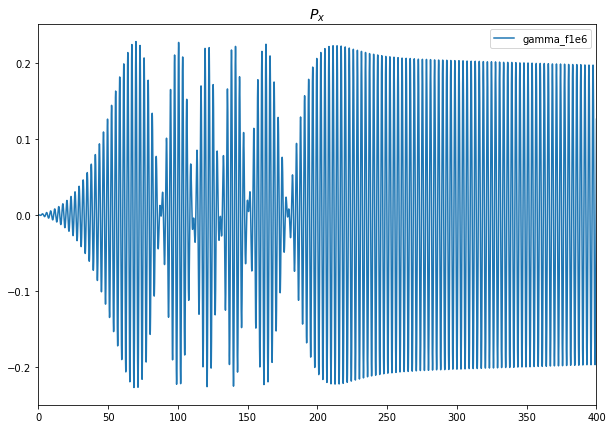

In [33]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

The other components of the polarization are essentialy zero as it should since we are
using a linear polarized pump along the $x$ axis.

Compare the lenght and velocity gauge

In [37]:
sel_sim = dict((k,simulations[k]) for k in ['gamma_f1e6','gamma_f1e6_vel'])

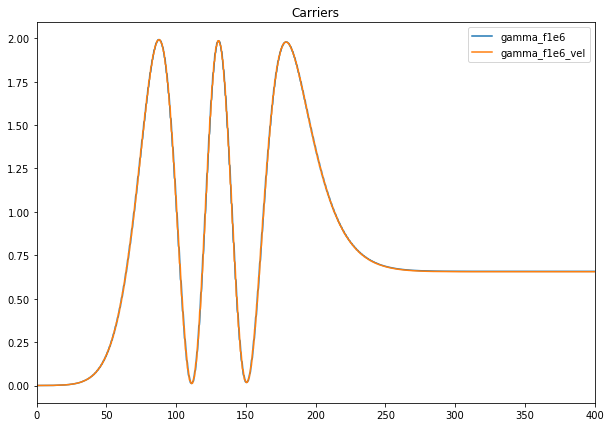

In [38]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

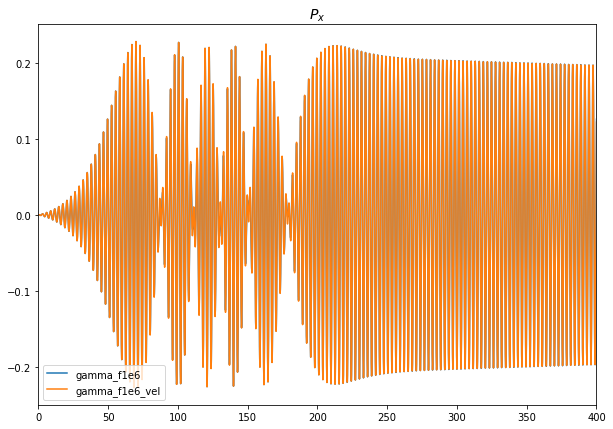

In [41]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    #plt.show()

It seems that the differences between the two gauges are negligible. Probably this due to the fact
that at $\Gamma$ states have definite angolar momentum and so the diagonal components of the
transition dipoles is zero. Further checks will be performed for other $k$ points.

We compute the FT of the polarization...is this a possible way to remove the high frequency 
components leaving only the slow modulation factor?

In [43]:
sel_sim = dict((k,simulations[k]) for k in ['gamma_f1e6'])
for study,val in sel_sim.items():
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']

In [51]:
hplanck = U.Planck_ev_ps*1e3 # Planck constant in ev*fs

N = len(time)
dt = time[1] - time[0]

freqs = np.fft.fftfreq(N, d=dt)
fplus = freqs[0:int(N/2)]
fourier = np.fft.fft(px)
fourierplus = fourier[0:int(N/2)]
fabs = np.sqrt(fourierplus.real**2+fourierplus.imag**2)

(0, 3)

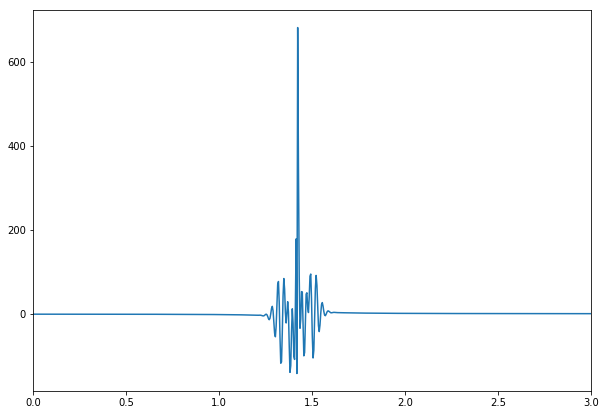

In [63]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(hplanck*fplus,fourierplus.real)
#plt.plot(hplanck*freqs,fourier.real)
plt.xlim(0,3)